This notebook determines the range of fire areas in which the 3 fire area datasets are in agreement by minimizing the Kuiper statistic of their CDFs over the region where the datasets overlap spatially and temporally.

In [4]:
import numpy as np
import geopandas as gpd
import os
import re
import pandas as pd
import sys

sys.path.append("..")
from utils.dataset_comparison import *

### MTBS vs. GFD

In [3]:
# REPLACE WITH PATH TO MTBS DOWNLOADED DATA
mtbs_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp")
mtbs_gdf = mtbs_gdf.set_crs("EPSG:4269")
mtbs_proj = mtbs_gdf.to_crs("EPSG:6933")

#REPLACE WITH PATH TO GFD DOWNLOADED DATA
idaho_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/ID_HFDB/HFD_HistoricFiresDatabase7_0.gdb", layer="Fires1950_Present")
idaho_gdf = idaho_gdf.to_crs("EPSG:6933")

mtbs_proj = mtbs_proj[(mtbs_proj["YEAR"] >= 1984) & (mtbs_proj["YEAR"] <= 2016)]
idaho_gdf = idaho_gdf[(idaho_gdf["FIRE_YEAR"] >= 1984) & (idaho_gdf["FIRE_YEAR"] <= 2016)]
idaho_gdf2 = idaho_gdf[(idaho_gdf["FIRE_YEAR"] >= 2003) & (idaho_gdf["FIRE_YEAR"] <= 2016)]

mtbs_proj["area_km2"] = mtbs_proj.geometry.area / 1e6
idaho_gdf["area_km2"] = idaho_gdf.geometry.area / 1e6
idaho_gdf2["area_km2"] = idaho_gdf2.geometry.area / 1e6

mtbs_overlap = gpd.sjoin(mtbs_proj, idaho_gdf[["geometry"]], predicate="intersects")
mtbs_overlap = mtbs_overlap.drop_duplicates(subset="FIRE_ID")

print_summary("MTBS", mtbs_overlap, "YEAR")
print_summary("Idaho", idaho_gdf, "FIRE_YEAR")

/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D MultiPolygon' is converted to 'MultiPolygon Z'
  return ogr_read(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(
/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py


MTBS dataset:
  Number of fires: 9208
  Year range: 1984 - 2016
  Mean fire size: 38.12 km²
  Median fire size: 11.87 km²
  Min fire size: 4.05 km²
  Max fire size: 2296.22 km²
  Total burned area: 350981.95 km²

Idaho dataset:
  Number of fires: 33354
  Year range: 1984 - 2016
  Mean fire size: 11.03 km²
  Median fire size: 0.67 km²
  Min fire size: 0.00 km²
  Max fire size: 2462.94 km²
  Total burned area: 367836.11 km²


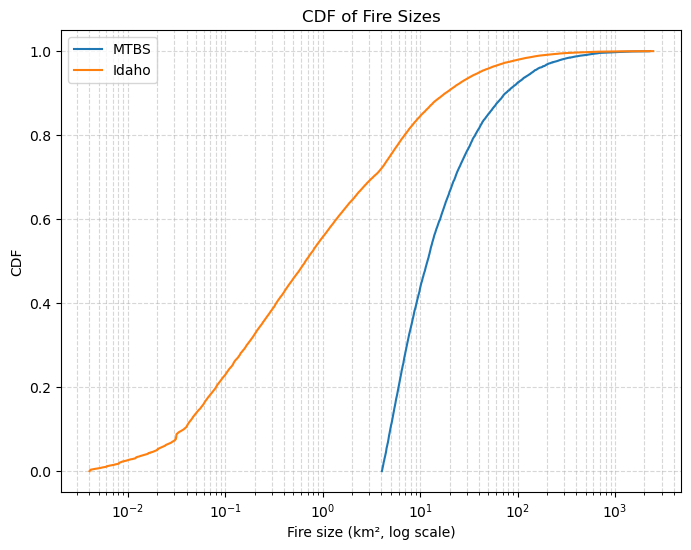

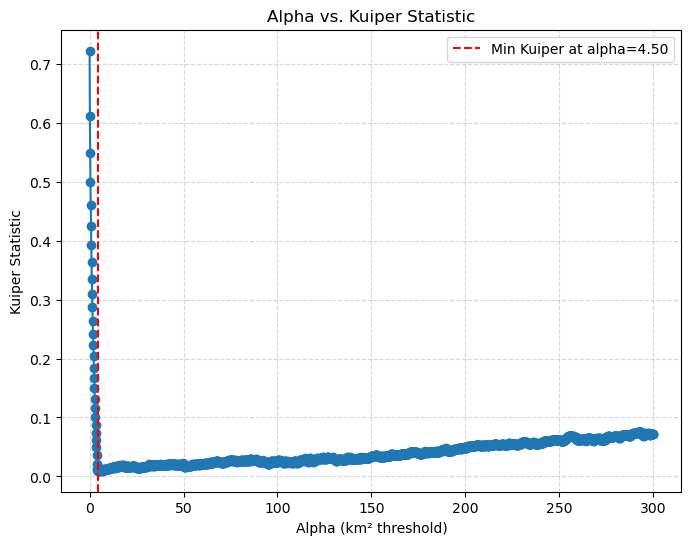

Minimum Kuiper statistic 0.0097 occurs at alpha = 4.5023 km²


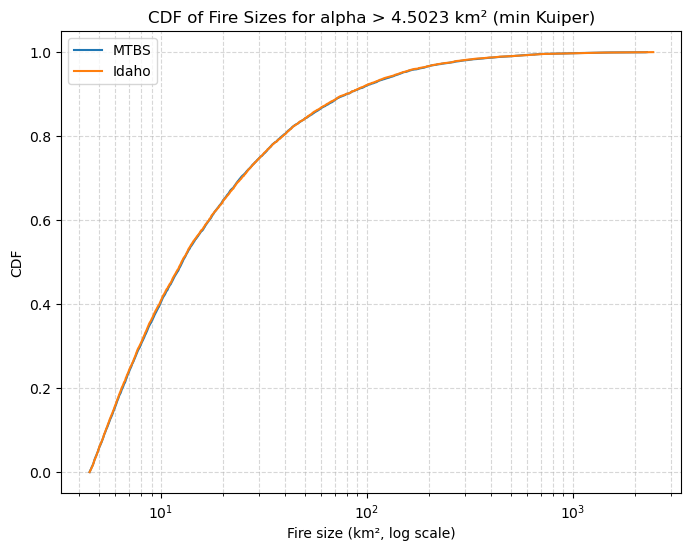

(np.float64(4.502251125562782), np.float64(0.009702622455945331))

In [5]:
alphas = np.linspace(0, 300, 2000)

plot_cdf_vs_area(mtbs_overlap, idaho_gdf)
plot_alpha_vs_kuiper_with_min_cdf(mtbs_overlap, idaho_gdf, alphas)

### GFA vs. GFD

In [6]:
#REPLACE WITH PATH TO DOWNLOADED GFA DATA
folder_path = "/Users/lukevonkapff/wildfires/CMS_GFA/data"
pattern = re.compile(r"Global_fire_atlas_V1_perimeter_\d{4}")

gfa_all_data = []

for gfa_folder_name in os.listdir(folder_path):
    if pattern.match(gfa_folder_name):
        gfa_folder_path = os.path.join(folder_path, gfa_folder_name)
        if os.path.isdir(gfa_folder_path):
            gfa_shp_path = os.path.join(gfa_folder_path, gfa_folder_name + ".shp")
            if os.path.exists(gfa_shp_path):
                print(f"Processing {gfa_shp_path} ...")
                gfa_gdf = gpd.read_file(gfa_shp_path)
                
                gfa_gdf = gfa_gdf.set_crs("EPSG:4326")
                gfa_gdf = gfa_gdf.to_crs("EPSG:6933")
                
                gfa_gdf["area_km2"] = gfa_gdf.geometry.area / 1e6
                gfa_gdf["perim_km"] = gfa_gdf.geometry.length / 1000

                gfa_year = int(re.search(r"\d{4}", gfa_folder_name).group())
                gfa_gdf["YEAR"] = gfa_year
                gfa_all_data.append(gfa_gdf)

gfa_combined_gdf = gpd.GeoDataFrame(pd.concat(gfa_all_data, ignore_index=True), crs="EPSG:6933")

gfa_overlap = gpd.sjoin(gfa_combined_gdf, idaho_gdf2[["geometry"]], predicate="intersects")
gfa_overlap = gfa_overlap.drop_duplicates(subset="geometry")

Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2005/Global_fire_atlas_V1_perimeter_2005.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2004/Global_fire_atlas_V1_perimeter_2004.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2003/Global_fire_atlas_V1_perimeter_2003.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2010/Global_fire_atlas_V1_perimeter_2010.shp ...


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2010/Global_fire_atlas_V1_perimeter_2010.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp ...


/Users/lukevonkapff/opt/anaconda3/envs/modis_env/lib/python3.10/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2016/Global_fire_atlas_V1_perimeter_2016.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2011/Global_fire_atlas_V1_perimeter_2011.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2006/Global_fire_atlas_V1_perimeter_2006.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2008/Global_fire_atlas_V1_perimeter_2008.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2009/Global_fire_atlas_V1_perimeter_2009.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2007/Global_fire_atlas_V1_perimeter_2007.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2014/Global_fire_atlas_V1_perimeter_2014.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_fire_atlas_V1_perimeter_2013/Global_fire_atlas_V1_perimeter_2013.shp ...
Processing /Users/lukevonkapff/wildfires/CMS_GFA/data/Global_f

In [7]:
print_summary("GFA (overlap)", gfa_overlap, "YEAR")
print_summary("Idaho", idaho_gdf2, "FIRE_YEAR")


GFA (overlap) dataset:
  Number of fires: 9399
  Year range: 2003 - 2016
  Mean fire size: 15.98 km²
  Median fire size: 2.36 km²
  Min fire size: 0.21 km²
  Max fire size: 1970.34 km²
  Total burned area: 150164.50 km²

Idaho dataset:
  Number of fires: 16134
  Year range: 2003 - 2016
  Mean fire size: 12.46 km²
  Median fire size: 0.53 km²
  Min fire size: 0.00 km²
  Max fire size: 2462.94 km²
  Total burned area: 201013.49 km²


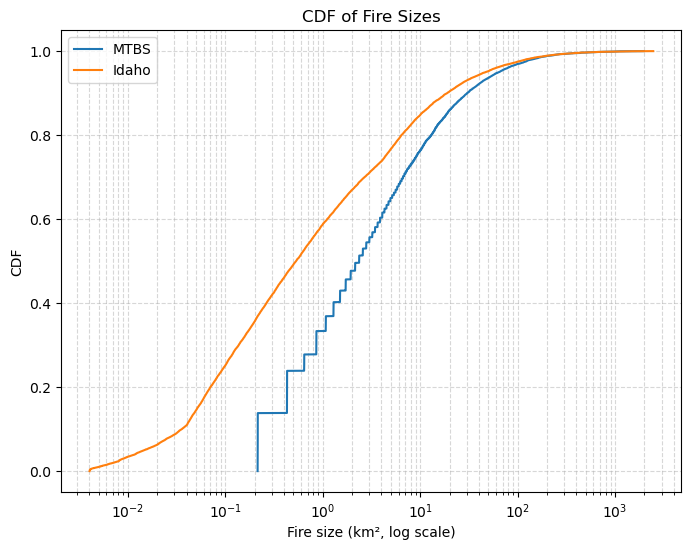

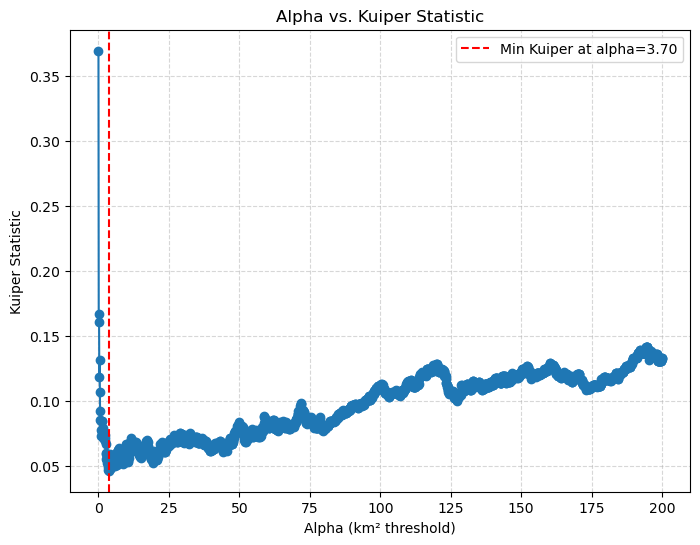

Minimum Kuiper statistic 0.0461 occurs at alpha = 3.7019 km²


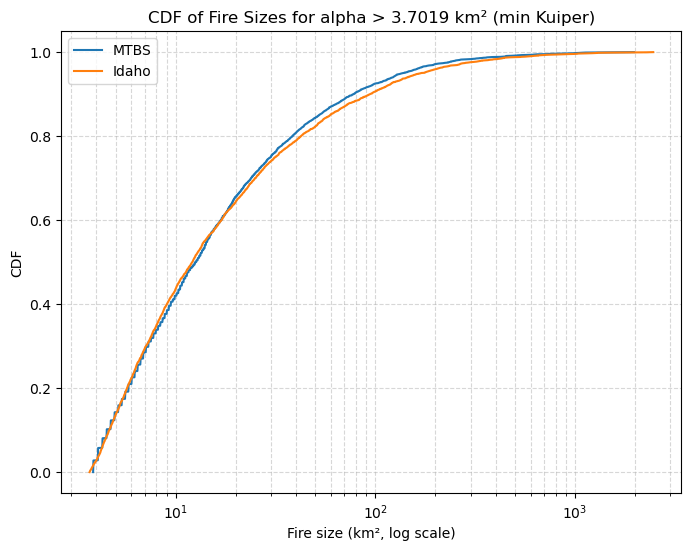

(np.float64(3.701850925462731), np.float64(0.046087608086439136))

In [8]:
alphas2 = np.linspace(0, 200, 2000)

plot_cdf_vs_area(gfa_overlap, idaho_gdf2)
plot_alpha_vs_kuiper_with_min_cdf(gfa_overlap, idaho_gdf2, alphas2)

### GFA vs. MTBS

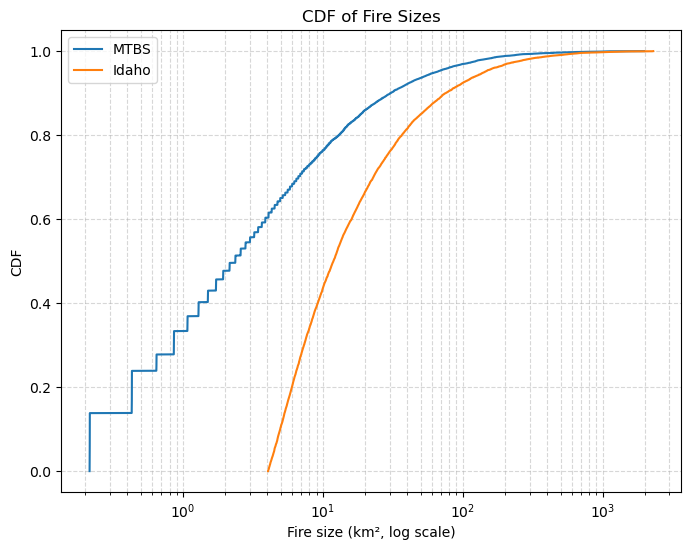

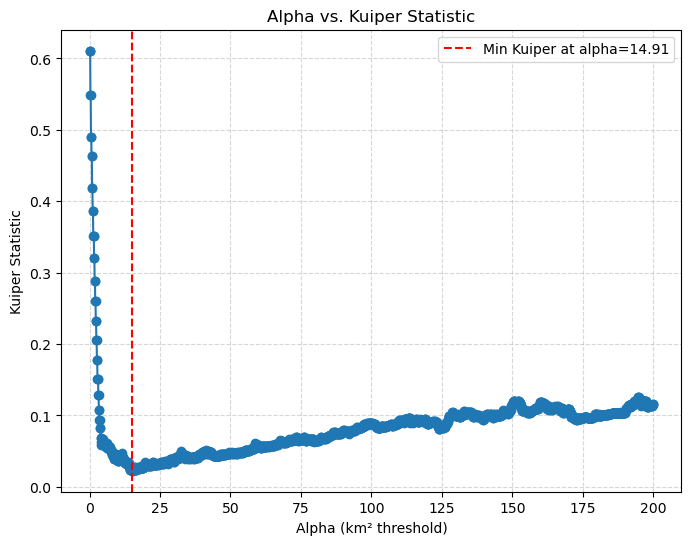

Minimum Kuiper statistic 0.0226 occurs at alpha = 14.9075 km²


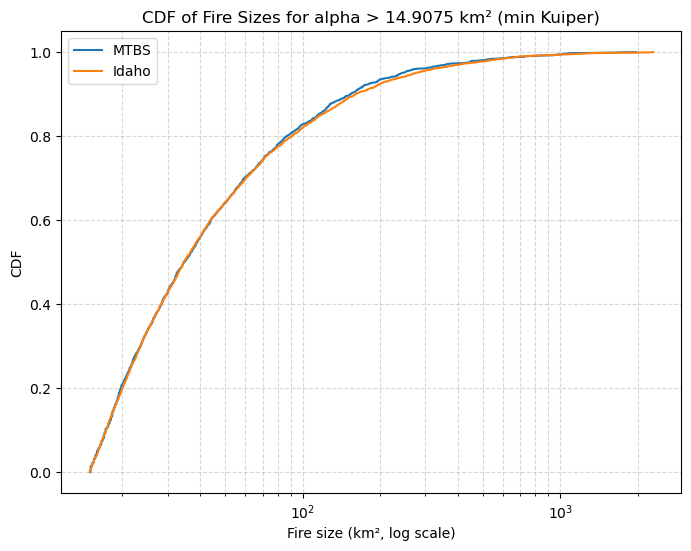

(np.float64(14.90745372686343), np.float64(0.02263925916620521))

In [9]:
plot_cdf_vs_area(gfa_overlap, mtbs_overlap)
plot_alpha_vs_kuiper_with_min_cdf(gfa_overlap, mtbs_overlap, alphas2)

Based on the minimum fire size cutoffs that minimize the Kuiper statistic, all future notebooks will remove fires less than 4 km^2.